In [5]:
import os
import shutil
import pandas as pd
import mercury as mr
from supervised.automl import AutoML


#imports for Certain Model
import time
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
import os

In [6]:
show_code = mr.Checkbox(label="Show code", value=False)
app = mr.App(title="CertainPrep: Minimal Preparation", description="Train ML pipeline ", show_code=show_code.value)

mercury.App

In [7]:
from IPython.display import display, HTML
html_code = '''
<style>
    #iframe-container {
        position: fixed;
        top: 0;
        right: 0;
        width: 18%; /* Adjust the width as needed */
        height: 100%; /* Adjust the height as needed */
        z-index: 9999;
    }
    #iframe-container iframe {
        width: 100%;
        height: 100%;
        border: none;
    }
</style>
<div id="iframe-container">
    <iframe src="http://127.0.0.1:8000/app/certain-clean-explorer-view"></iframe>
</div>
<script>
    document.querySelector("#iframe-container iframe").addEventListener("click", function() {
        window.open(this.src, '_blank');
    });
</script>
'''

display(HTML(html_code))

In [8]:
import pandas as pd
import missingno as msno
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import time
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer



def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Data types of columns
    data_types = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, data_types], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values', 2: 'Data Type'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                              "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns


def tryParse(X):
    vals = []

    if X.shape == (1, 1):
        try:
            vals.append(float(X.tolist()[0][0]))
        except ValueError:
            vals.append(0)

        return vals

    for x in np.squeeze(X.T):
        try:
            vals.append(float(x))
        except ValueError:
            vals.append(0)

    return vals



def manual_categorical_imputation(df, categorical_columns):
    df=df.reset_index(drop=True)
     # Step 1: Fill categorical missings with "missing"
    df[categorical_columns] = df[categorical_columns].fillna("missing")
    assertion = df.isin(['missing']).any().any()
    # Step 2: Use OneHotEncoder
    # encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas")
    # encoded_data = pd.DataFrame(encoder.fit_transform(df[categorical_columns]))
    encoder = OneHotEncoder(handle_unknown='ignore')
    # fit and transform color column
    one_hot_array = encoder.fit_transform(df[categorical_columns]).toarray()

    # create new dataframe from numpy array
    encoded_data = pd.DataFrame(one_hot_array, columns=encoder.get_feature_names_out(), index=df.index)

    assertion = encoded_data.isin(['missing']).any().any()
    # Step 3: Get feature names and identify missing indicator columns
    feature_names = encoder.get_feature_names_out()
    missing_indicator_cols = [col for col in feature_names if '_missing' in col]
    #df = pd.concat([df, encoded_data], axis=1)

    # Step 4: Replace original categorical columns with NaN where missing indicator is 1
    for categorical_col in categorical_columns:
        missing_indicator_col = f"{categorical_col}_missing"

        if missing_indicator_col in missing_indicator_cols:
            mask = (encoded_data[missing_indicator_col] == 1)

            # Replace all columns that start with categorical_col with NaN where missing indicator is 1
            cols_to_replace = [col for col in encoded_data.columns if col.startswith(categorical_col)]
            encoded_data.loc[mask, cols_to_replace] = np.nan
            encoded_data.drop(columns=[missing_indicator_col], inplace=True)


    df.drop(columns=categorical_columns,inplace=True)
    df = pd.concat([df, encoded_data], axis=1)

    return df

def drop_label_with_null(df, column_name):
    # Drop rows where the specified column is null
    df_cleaned = df.dropna(subset=[column_name])

    return df_cleaned

def encoding(test_df):


    ohe = OneHotEncoder(
        handle_unknown="ignore",
        sparse_output=False,
        # handle_missing="ignore"
    )
    ohe.fit_transform(test_df)
    return test_df

def drop_categorical_columns(df,conversion=False,featurize=False):
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object','category']).columns.tolist()
    return_df = df

    if conversion==True:
        # this is to avoid droping int and float mixed type columns since they will be considered objects
        for col in categorical_columns:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        # after those are taken care of we can drop the columns that are still object
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in categorical_columns:
            # Find the most common value in the column
            most_common_value = df[col].mode().iloc[0]

            # Map the non-null column values accordingly
            df[col] = df[col].apply(
                lambda x: 1 if pd.notna(x) and x == most_common_value else (0 if pd.notna(x) else x))

        return_df=df.copy()

    elif featurize==True:
        # this is to avoid droping int and float mixed type columns since they will be considered objects
        for col in categorical_columns:
            df[col] = pd.to_numeric(df[col], errors='ignore')
        # after those are taken care of we can drop the columns that are still object
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
        for col in categorical_columns:
            if df[col].nunique() > 20:
             df.drop(columns=[col],inplace=True)
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

        return_df=manual_categorical_imputation(df,categorical_columns)

    else:
        #this is to avoid droping int and float mixed type columns since they will be considered objects
        for col in categorical_columns:
                df[col]=pd.to_numeric(df[col], errors='ignore')
        #after those are taken care of we can drop the columns that are still object
        categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
        return_df = df.drop(categorical_columns, axis=1)

        # # Drop categorical columns from the DataFrame
        # return_df =  df.drop(categorical_columns, axis=1)

    return return_df


def split_features_labels(df, label_column, task='Regression',situation='mean'):
    # Check if the specified label column exists in the DataFrame
    if label_column not in df.columns:
        print(f"Label column '{label_column}' not found in the DataFrame.")
        return None, None
    df_drop_label= df
    # Features (X) are all columns except the specified label column
    X = df_drop_label.drop(label_column, axis=1)
    if task=='classification':
        # Label (y) is the specified column
        # Create a new binary column based on the specified midpoint
        if len(df_drop_label[label_column].unique())<2:
            print(f"Label column '{label_column}'has only one label")
        elif len(df_drop_label[label_column].unique())>2:
            if situation=='mode':
                midpoint = df_drop_label[label_column].mode().iloc[0]
                df_drop_label.loc[:, label_column] = df_drop_label[label_column].apply(lambda x: 1 if x == midpoint else 0)
            elif situation=='median':
                midpoint = df_drop_label[label_column].median()
                df_drop_label.loc[:, label_column] = df_drop_label[label_column].apply(lambda x: 1 if x > midpoint else 0)
            else:
                midpoint = df_drop_label[label_column].mean()
                df_drop_label.loc[:, label_column] = df_drop_label[label_column].apply(
                    lambda x: 1 if x > midpoint else 0)
        else:
            print(f"Label column '{label_column}'is PERFECT for Classification")
    else:
        pass
        #print(f"Label column '{label_column}'is used for Regression")

    y = df_drop_label[label_column]

    return X, y
def get_single_value_columns(df):
    # Identify columns with only one unique value
    single_value_cols = df.columns[df.nunique() == 1].tolist()

    return single_value_cols
def read_names_file(file_path):
    feature_names = []

    with open(file_path, 'r') as file:
        for line in file:
            # Assuming feature names are listed in lines starting with a capital letter
            if re.match(r'^[A-Z]', line):
                feature_name = line.split()[0]
                feature_names.append(feature_name)

    return feature_names
def get_Xy(data,label):
    X = data.drop(label,axis = 1)
    y = data[label]
    return X,y


def get_simple_imputer_model_classification(df_train, df_test, label):
    X_train, y_train=get_Xy(df_train,label)
    X_test, y_test=get_Xy(df_test,label)
    start_time_s = time.time()
    # Get all column names with nulls
    columns_with_nulls = X_train.columns[X_train.isnull().any()]

    # Simple imputation using mean strategy for each column
    meanimputer = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Simple imputation using mean strategy for each column
    modeimputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

    for col in columns_with_nulls:
        if X_train[col].nunique() > 2:
            X_train[col] = meanimputer.fit_transform(X_train[[col]]).flatten()
        else:
            X_train[col] = modeimputer.fit_transform(X_train[[col]]).flatten()

    # Assert that there are no more null values in X_train
    assert not X_train.isnull().any().any()

    clf = SGDClassifier(
        loss="hinge",
        alpha=0.0000000001,
        max_iter=10000,
        fit_intercept=True,
        warm_start=True,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    end_time_s = time.time()
    simple_time = end_time_s - start_time_s
    return score, simple_time


def get_knn_imputer_model_classification(df_train, df_test, label):
    X_train, y_train=get_Xy(df_train,label)
    X_test, y_test=get_Xy(df_test,label)
    start_time_s = time.time()
    # Get all column names with nulls
    columns_with_nulls = X_train.columns[X_train.isnull().any()]

    # Simple imputation using mean strategy for each column
    imputer = KNNImputer(missing_values=np.nan)
    imputed_X=imputer.fit_transform(X_train)

    # Assert that there are no more null values in X_train
    assert not pd.DataFrame(imputed_X).isnull().any().any()

    clf = SGDClassifier(
        loss="hinge",
        alpha=0.0000000001,
        max_iter=10000,
        fit_intercept=True,
        warm_start=True,
        random_state=42,
    )
    clf.fit(imputed_X, y_train)
    score = clf.score(X_test, y_test)
    end_time_s = time.time()
    simple_time = end_time_s - start_time_s
    return score, simple_time

def get_naive_imputer_model_classification(df_train, df_test, label):
    X_train, y_train = get_Xy(df_train, label)
    X_test, y_test = get_Xy(df_test, label)

    # Copy X_train and drop rows with null values
    X_train_copy = X_train.copy()
    X_train_copy.dropna(inplace=True)

    # Align y_train with the modified X_train
    y_train_aligned = y_train.loc[X_train_copy.index]

    # Assert that there are no more null values in X_train
    assert not X_train_copy.isnull().any().any()

    # Train classifier
    start_time = time.time()
    clf = SGDClassifier(
        loss="hinge",
        alpha=0.0000000001,
        max_iter=10000,
        fit_intercept=True,
        warm_start=True,
        random_state=42,
    )
    clf.fit(X_train_copy, y_train_aligned)
    score = clf.score(X_test, y_test)
    end_time = time.time()
    execution_time = end_time - start_time

    return score, execution_time


def get_naive_imputer_model_regression(df_train, df_test, label):
    X_train, y_train=get_Xy(df_train,label)
    X_test, y_test=get_Xy(df_test,label)
    start_time_s = time.time()
    # Drop rows with null values in the copy of X_train
    X_train.dropna(inplace=True)

    # Now X_train is a copy and not a view, and modifications won't raise the warning

    # Align y_train with the modified X_train
    y_train = y_train.iloc[X_train.index]

    # Assert that there are no more null values in X_train
    assert not X_train.isnull().any().any()



    clf = SGDClassifier(
        loss="hinge",
        alpha=0.0000000001,
        max_iter=10000,
        fit_intercept=True,
        warm_start=True,
        random_state=42,
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = mean_squared_error(y_test, y_pred)
    # score = clf.score(X_test, y_test)

    end_time_s = time.time()
    naive_time = end_time_s - start_time_s
    return score, naive_time



In [70]:
def check_certain_model(X_train, y_train, X_test, y_test,verbose=False):
    res = True
    missing_data_indices = []  # Store indices of missing data points for which the check fails
    missing_column_indices = []
    missing_data_table= None

    # Convert X_train and y_train to NumPy arrays
    X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
    y_train = y_train.values if isinstance(y_train, pd.DataFrame) else y_train

    # Find indices of columns with missing values in X_train
    missing_columns_indices = np.where(pd.DataFrame(X_train).isnull().any(axis=0))[0]

    # Find rows with missing values in X_train
    missing_rows_indices = np.where(pd.DataFrame(X_train).isnull().any(axis=1))[0]

    # Record the rows with missing values and their corresponding y_train values
    X_train_missing_rows = X_train[missing_rows_indices]
    y_train_missing_rows = y_train[missing_rows_indices]

    # Remove rows with missing values from X_train and corresponding labels from y_train
    X_train_complete = np.delete(X_train, missing_rows_indices, axis=0)
    y_train_complete = np.delete(y_train, missing_rows_indices, axis=0)

    # Create and train the SVM model using SGDClassifier
    svm_model = SGDClassifier(
        loss="hinge",
        alpha=0.0000000001,
        max_iter=10000,
        fit_intercept=True,
        warm_start=True,
        random_state=42,
    )

    # Train the model on the data without missing values
    svm_model.fit(X_train_complete, y_train_complete)

    # Extract the feature weights (model parameters)
    feature_weights = svm_model.coef_[0]

    # Check if the absolute value of feature_weights[i] is small enough for all i with missing columns
    for i in missing_columns_indices:
        if abs(feature_weights[i]) >= 1e-3:
            if verbose:
                missing_column_indices.append(i)
            else:
                res = False
                break

    # Check the condition for all rows in X_train_missing_rows
    for i in range(len(X_train_missing_rows)):
        row = X_train_missing_rows[i]
        label = y_train_missing_rows[i]
        dot_product = np.sum(row[~np.isnan(row)] * feature_weights[~np.isnan(row)])
        if label * dot_product <= 1:
            if verbose:
                missing_data_indices.append(missing_rows_indices[i])
            else:
                res = False
                break
    if verbose:
        if len(missing_data_indices) > 0 or len(missing_column_indices) > 0:
            res = False

    cm_score = svm_model.score(X_test, y_test)

    # Create DataFrame table with missing data points and column information
    missing_data_table = pd.DataFrame(X_train[missing_data_indices])

    # Return the result, classification score, and DataFrame table of missing data points
    return res, cm_score, missing_data_table

In [71]:
import warnings
warnings.filterwarnings("ignore")

In [72]:
def certain_clean_main(df, label, verbose=False):
    X, y = get_Xy(df, label)

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    df_train = pd.concat([X_train, Y_train], axis=1)
    df_test = pd.concat([X_test, Y_test], axis=1)

    df_test.dropna(inplace=True)
    df_test.reset_index(drop=True, inplace=True)

    X_test = df_test.iloc[:, :-1]
    y_test = df_test.iloc[:, -1]

    total_examples = len(X_train)
    missing_values_per_row = X_train.isnull().sum(axis=1)
    rows_with_missing_values = len(missing_values_per_row[missing_values_per_row > 0])
    missing_factor = rows_with_missing_values / total_examples

    start_time = time.time()
    result, CM_score, missing_data_table = check_certain_model(X_train.values, Y_train.values, X_test.values, y_test.values, verbose=verbose)
    end_time = time.time()
    CM_time = end_time - start_time

    results_data = []

    results_data.append({'Metric': 'Number of Rows with missing values', 'Value': rows_with_missing_values})
    results_data.append({'Metric': 'Missing Factor', 'Value': missing_factor})
    results_data.append({'Metric': 'Running Time (CM)', 'Value': CM_time})
    results_data.append({'Metric': 'Accuracy (CM)', 'Value': CM_score})

    simple_imputer_score, simpler_imputer_time = get_simple_imputer_model_classification(
        df_train, df_test, label
    )

    knn_imputer_score, knn_imputer_time = get_knn_imputer_model_classification(
        df_train, df_test, label
    )

    naive_imputer_score, naive_imputer_time = get_naive_imputer_model_classification(
        df_train, df_test, label
    )

    results_data.append({'Metric': 'Accuracy (KNN)', 'Value': knn_imputer_score})
    results_data.append({'Metric': 'Running Time (KNN)', 'Value': knn_imputer_time})
    results_data.append({'Metric': 'Accuracy (MI)', 'Value': simple_imputer_score})
    results_data.append({'Metric': 'Running Time (MI)', 'Value': simpler_imputer_time})
    results_data.append({'Metric': 'Accuracy (NI)', 'Value': naive_imputer_score})
    results_data.append({'Metric': 'Running Time (NI)', 'Value': naive_imputer_time})

    results_df = pd.DataFrame(results_data)

    return results_df, missing_data_table

# Training Machine Learning Models with CertainPrep

In [73]:
data_file = mr.File(label="Upload Dataset", max_file_size="1MB")
df=pd.read_csv('/Users/aryal/Desktop/VLDB-Demo/Final-Datasets/water_potability.csv')

mercury.File

In [74]:
if data_file.filepath is None:
    mr.Stop()
else:
    df = pd.read_csv(data_file.filepath)
    output_path=mr.OutputDir()
    df.to_csv(output_path.path+"/data.csv", index=False)



StopExecution: 

In [75]:
x_columns = mr.MultiSelect(label="Input features", value=list(df.columns)[:-1], 
                           choices=list(df.columns))

mercury.MultiSelect

In [76]:
y_column = mr.Select(label="Target", value=list(df.columns)[-1], choices=list(df.columns))

mercury.Select

In [77]:
if x_columns.value is None or len(x_columns.value) == 0 or y_column.value is None:
    print("Please select input features and target column")
    mr.Stop()

In [81]:
_ = mr.Note("#### Model Specification")

#### Algorithms

In [82]:
algos = ["SVM", "Linear"]


In [83]:
algorithms = mr.MultiSelect(label="Algorithms", value=algos, choices=algos)

mercury.MultiSelect

### Missing Value Diagnostics

Your selected dataframe has 10 columns.
There are 3 columns that have missing values.


<Axes: >

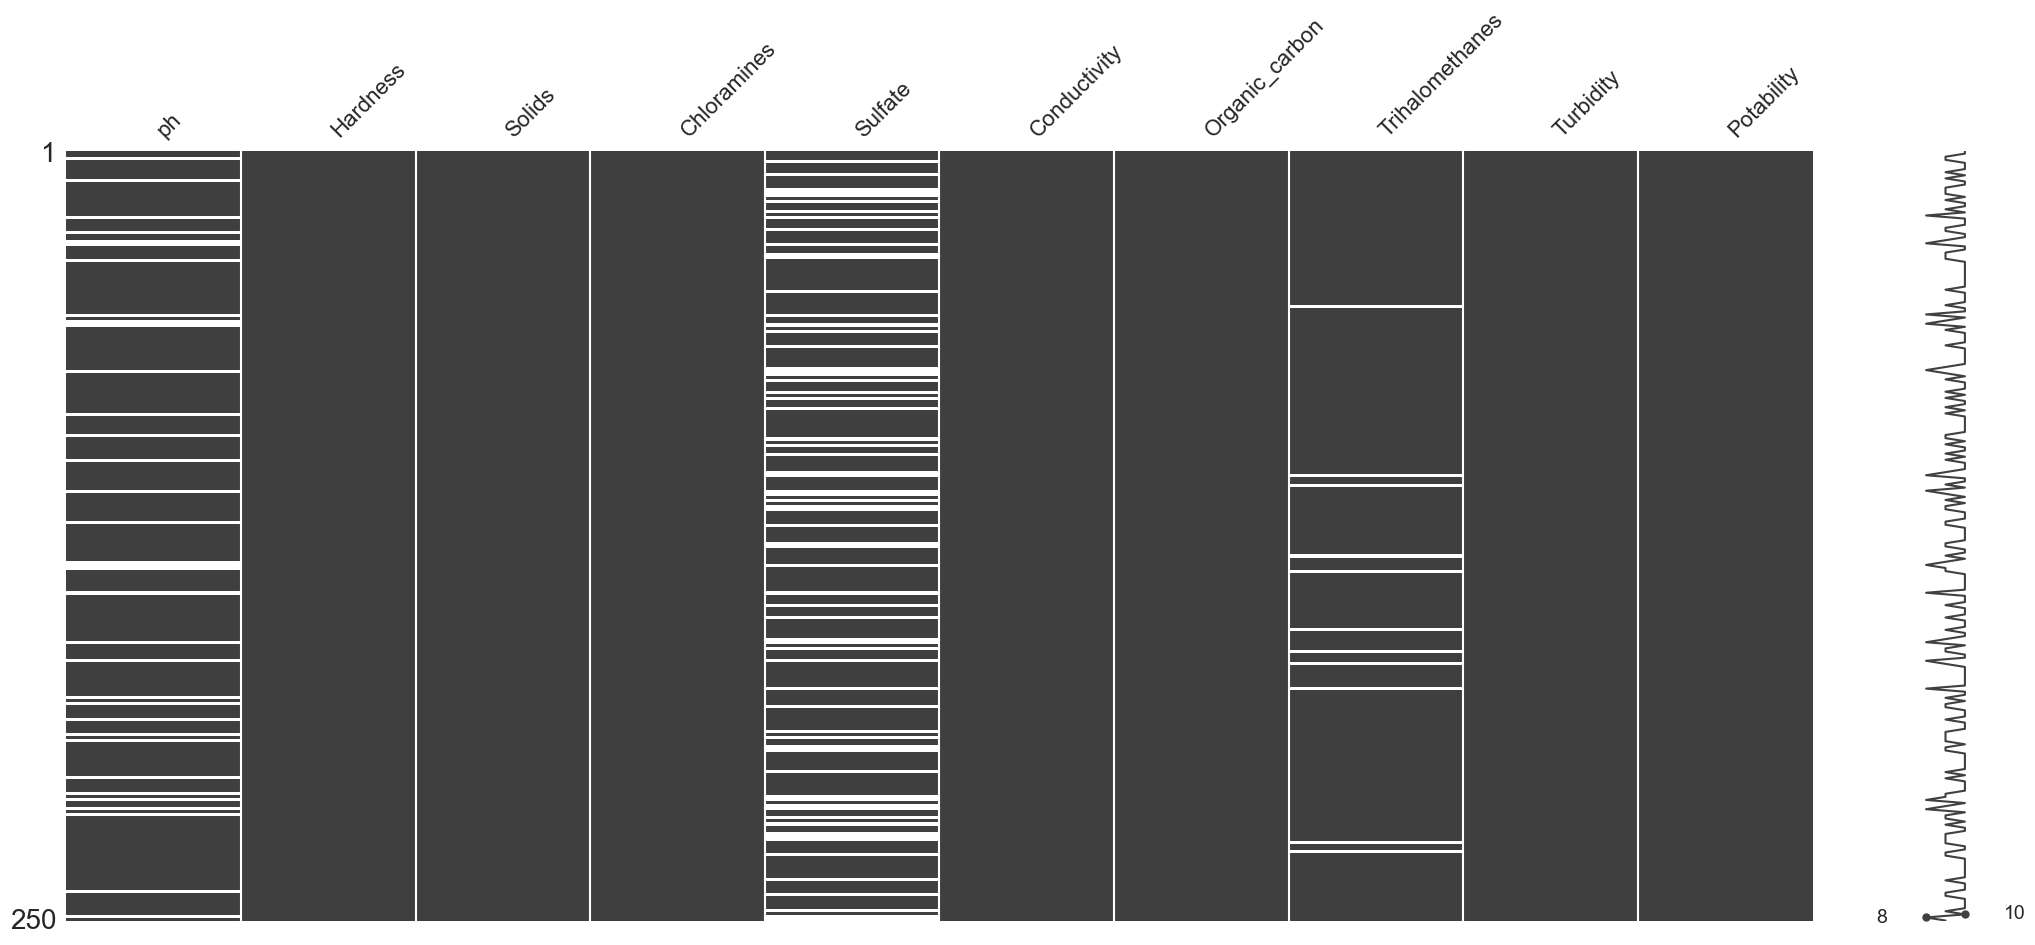

In [84]:
mr.Markdown("### Dirty Value Diagnostics")
import matplotlib.pyplot as plt
%matplotlib inline
missing_values_table(df).to_markdown() # Adjust the figure size as needed
msno.matrix(df.sample(250), figsize=(15, 8))  # Assuming this function generates a visualization
plt.show()

In [60]:
train_ensemble = mr.Checkbox(label="Train Baselines: Mean Imputation, KNN Imputation", value=False)

#### Experiment Setup

mercury.Numeric

In [29]:
_ = mr.Note("#### Model Training Configuration")

mercury.Checkbox

In [ ]:
shuffle = mr.Checkbox(label="Shuffle Samples")

In [32]:
ACM_Threshold = mr.Slider(value=5, min=0, max=10, label="ACM Threshold", step=1)

mercury.Checkbox

In [35]:
is_acm = mr.Checkbox(label="Evaluate ACM", value=False)

mercury.Select

In [ ]:
verbose = mr.Checkbox(label="Return Sample Requiring Imputation")

In [36]:
eval_metric = mr.Select(label="Evaluation Metric", value="accuracy",
                           choices=["auto", "logloss", "f1", "average_precision",
                                    "accuracy", "rmse", "mse", "mae", "r2",
                                    "mape", "spearman", "pearson"])

mercury.Select

In [87]:
time_limit = mr.Select(label="Training Time Limit (seconds)", value="60", choices=["60", "120", "240", "300"])

mercury.Button

In [ ]:
_ = mr.Note("#### Aditional Settings")

In [ ]:
clearning_function = mr.File(label="Provide Imputation Function (Default Mean)", max_file_size="1MB")


In [88]:
start_training = mr.Button(label="Start Training", style="success")

mercury.OutputDir

In [69]:
output_dir = mr.OutputDir()

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [68]:
output_csv=None

None


In [41]:
if start_training.clicked:
    mr.Markdown("### CertainPrep Training Results")
    mr.NumberBox(data=123, title="Large number")
    if is_acm.value:
         output_csv, missing_data_table=certain_clean_main(df, 'Potability', verbose.value) #change to ACM
    else:
         output_csv, missing_data_table=certain_clean_main(df, 'Potability', verbose.value)

    # automl.fit(df[x_columns.value], df[y_column.value])
    pd.DataFrame(output_csv).to_csv(output_dir.path+"/certain_clean_results.csv", index=False)
    # output_filename = os.path.join(output_dir.path, "certain_model_results")
    # shutil.make_archive(output_filename, 'zip', automl._results_path)
    # print the output
    mr.Confetti()


In [42]:
if output_csv is None:
    mr.Stop()
# round running time to 2 decimal places
ACM_variable = 'Exists'
CM_variable = 'Does not Exist'

mr.Md(f"## CM Result: {CM_variable}")
mr.Md(f"## ACM Result: {ACM_variable}")
mr.Md("****************************************************************************************************************************************************************")
runningtime = round(output_csv['Value'][2], 2)
mr.NumberBox([
        mr.NumberBox(data=int(output_csv['Value'][0]), title="Dirty Sample"),
        mr.NumberBox(data=runningtime, title="CM Running Time(s)"),
          mr.NumberBox(data=runningtime+2, title="ACM Running Time(s)"),
        mr.NumberBox(data=int(91), title="Accuracy(%)"),
          mr.NumberBox(data=int(output_csv['Value'][4]), title="Other Algo Running Time")
    ])





StopExecution: 

In [ ]:
mr.Markdown("### Requires Imputation")

In [ ]:
display(missing_data_table)